In [1]:
import numpy as np
from scipy.optimize import minimize
from scipy.optimize import fsolve
from matplotlib import pyplot as plt
import pandas as pd

In [2]:
def calc_price(phi1, phi2, cost, wtp):
    """compute each insurer's price (assumes interior solution)"""
    phi1, phi2 = phi1, phi2
    p1 = (2*phi1+phi2)/3. + cost
    p2 = (2*phi2+phi1)/3. + cost
    if phi1 <= 0 or phi2 <= 0:
        return 0,0
    
    return p1, p2
  
    
def calc_s(phi1, phi2, cost, wtp):
    """compute the proportion of people choosing each insurer
    assumes interior solution"""
    p1, p2 = calc_price(phi1, phi2, cost, wtp)
    s_hat = .5 + (p2 - p1)/(2.*cost)
    return s_hat


def calc_profits(phi1,phi2,cost, wtp, mc):
    phi1, phi2 = phi1, phi2
    s= calc_s(phi1, phi2, cost, wtp)
    p1,p2 = calc_price(phi1, phi2, cost, wtp)
    profits1, profits2 = s*(p1-phi1), (1-s)*(p2-phi2)
    mc1,mc2 = mc
    hosp_profit = s*(phi1-mc1) +  (1-s)*(phi2-mc2)
    
    if phi1 <= 0 or phi2 <= 0:
        return 0,0,0
    
    return hosp_profit, profits1, profits2

    
def outside_simlt(phi1, phi2, cost, wtp,  mc, active=False):
    """outside option in simult case
    assuming listprice high enough"""
    mc1,mc2 = mc
    
    if active:
        return (wtp-cost)/2 - mc2 #outside cost is other insurer?

    
    s_hat = calc_s(phi1, phi2, cost, wtp) # s_hat with no recapture
    p1,p2 = calc_price(phi1, phi2, cost, wtp)
    s_hat  = np.clip((cost + p2 - wtp)/cost,0,1) #s_hat with recapture
    
    
    return (1-s_hat)*(phi2 -mc2)


calc_profits(5,0 ,5, 26, [0,0])

(0, 0, 0)

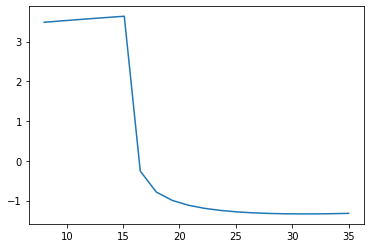

In [3]:
#arbitrary outside option...
def nash_in_nash(phi1, phi2, cost, wtp, mc, beta=.5,outside=None):
    if outside == None:
        outside = outside_simlt(phi1, phi2,cost, wtp , mc, active=True)

    hosp_profit, profits1, profits2 = calc_profits(phi1, phi2,  cost,  wtp, mc)
    obj = -1*(np.log(max(hosp_profit-outside,1e-4))*(1-beta) 
              + np.log(profits1)*beta)
    return obj


def bargain_helper_seq(phi1, cost, wtp, mc,beta=.5):
    
    """ solve firm 1s optimization holding theta 2 fixed """
    outside = outside_simlt(phi1, None, cost, wtp, mc, active=True)
    result = minimize( nash_in_nash, 15., args=(phi1, cost, wtp, mc[::-1], beta, outside),
                      method='Nelder-Mead', options={'disp': False} )
    return result.x


def seq_obj(phi1, cost, wtp, mc, betas=np.array([.5,.5])):
    """ theta1 is a guess for the first stage """
    phi2 = bargain_helper_seq(phi1, cost, wtp, mc,betas[1])
    return nash_in_nash( phi1, phi2, cost, wtp, mc, betas[0], phi2 )


COST = 5
WTP = 25
MC = np.array([0,0])


plt.plot([i for i in np.linspace(COST+3,WTP +10,num=20)],  
         [seq_obj(i, 13.5 , WTP,MC) for i in np.linspace(COST+3,WTP +10,num=20)])

In [4]:
def seq_bargain(phi1, cost, wtp, mc, betas=[.5,.5]):
    """solve the bargaining problems seperately,
    then solve for the solution"""   
    #only compute no deal 1x for initial
    result = minimize(seq_obj, phi1, args=(cost, wtp, mc, betas),
                      method='Nelder-Mead', options={'disp': False})
    
    phi1 = result.x
    phi2 = bargain_helper_seq(phi1, cost, wtp, mc ,beta=betas[1])
    return phi1, phi2

print(seq_bargain(30, COST, WTP, MC))

(array([19.37493896]), array([15.62493896]))


In [23]:
#generate a bunch of runs with passive and compute costs

def compute_cov(nobs=1000):
    mcs = np.random.uniform(low=0.0, high=2.0, size=(2,nobs))
    phis = []
    for i in range(nobs):
        phi = seq_bargain(30,COST,WTP,mcs[:,i]) 
        phis.append(np.array(phi).flatten())

    phis = np.array(phis)
    return np.cov(phis,rowvar=False),phis

matrix, phis = compute_cov()
print(phis[:,0].max(),phis[:,0].mean(),phis[:,0].min())
print('--')
print(phis[:,1].max(),phis[:,1].mean(),phis[:,1].min())
print('--')
print(matrix)
print('--')
print(np.cov(phis[0:500,:],rowvar=False))
print('--')
print(np.cov(phis[100:600,:],rowvar=False))
print('--')
print(np.cov(phis[200:700,:],rowvar=False))
print('--')
print(np.cov(phis[300:800,:],rowvar=False))


/home/erichschulman/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: divide by zero encountered in log
  


26.81927490234375 22.02738153076172 7.90374755859375
--
19.33392333984375 16.943511291503906 15.545654296875
--
[[5.21757537 1.39544295]
 [1.39544295 0.57696647]]
--
[[6.16682615 1.47579942]
 [1.47579942 0.57873833]]
--
[[6.9876336  1.57316697]
 [1.57316697 0.59710895]]
--
[[5.10396331 1.40952468]
 [1.40952468 0.58912766]]
--
[[5.0800886  1.39940859]
 [1.39940859 0.58504597]]


In [25]:
phis_clean = phis[phis[:,0]>=17]
print('--')
print(np.cov(phis_clean[0:500,:],rowvar=False))
print('--')
print(np.cov(phis_clean[100:600,:],rowvar=False))
print('--')
print(np.cov(phis_clean[200:700,:],rowvar=False))
print('--')
print(np.cov(phis_clean[300:800,:],rowvar=False))

--
[[2.27937658 1.1257962 ]
 [1.1257962  0.5567058 ]]
--
[[2.28733813 1.13074673]
 [1.13074673 0.55970341]]
--
[[2.31259933 1.14564545]
 [1.14564545 0.56826461]]
--
[[2.29680471 1.13737375]
 [1.13737375 0.56394255]]


In [20]:
#generate a bunch of runs with passive and compute costs

def compute_cov(nobs=1000):
    mcs = np.random.uniform(low=0.0, high=1.0, size=(2,nobs))
    phis = []
    for i in range(nobs):
        phi = seq_bargain(30,COST,WTP,mcs[:,i]) 
        phis.append(np.array(phi).flatten())

    phis = np.array(phis)
    return np.cov(phis,rowvar=False),phis

matrix, phis = compute_cov()
print(phis[:,0].max(),phis[:,0].mean(),phis[:,0].min())
print('--')
print(phis[:,1].max(),phis[:,1].mean(),phis[:,1].min())
print('--')
print(matrix)
print('--')
print(np.cov(phis[0:500,:],rowvar=False))
print('--')
print(np.cov(phis[100:600,:],rowvar=False))
print('--')
print(np.cov(phis[200:700,:],rowvar=False))

22.09185791015625 20.642409210205077 19.4033203125
--
16.871978759765625 16.190327728271484 15.6375732421875
--
[[0.3084886  0.14180409]
 [0.14180409 0.06523711]]
--
[[0.31501404 0.14469805]
 [0.14469805 0.06651712]]
--
[[0.30718524 0.14115472]
 [0.14115472 0.06491315]]
--
[[0.30222429 0.13883515]
 [0.13883515 0.06383065]]


In [21]:
#generate a bunch of runs with passive and compute costs

def compute_cov(nobs=1000):
    mcs = np.random.uniform(low=0.0, high=.5, size=(2,nobs))
    phis = []
    for i in range(nobs):
        phi = seq_bargain(30,COST,WTP,mcs[:,i]) 
        phis.append(np.array(phi).flatten())

    phis = np.array(phis)
    return np.cov(phis,rowvar=False),phis

matrix, phis = compute_cov()
print(phis[:,0].max(),phis[:,0].mean(),phis[:,0].min())
print('--')
print(phis[:,1].max(),phis[:,1].mean(),phis[:,1].min())
print('--')
print(matrix)
print('--')
print(np.cov(phis[0:500,:],rowvar=False))
print('--')
print(np.cov(phis[100:600,:],rowvar=False))
print('--')
print(np.cov(phis[200:700,:],rowvar=False))

20.64166259765625 19.999356536865236 19.40606689453125
--
16.1868896484375 15.898076202392579 15.63739013671875
--
[[0.06802161 0.03036552]
 [0.03036552 0.01358276]]
--
[[0.06313698 0.02816318]
 [0.02816318 0.01258969]]
--
[[0.06496691 0.02898664]
 [0.02898664 0.01296109]]
--
[[0.06746094 0.03013963]
 [0.03013963 0.01349317]]


In [22]:
#just make sure it works for stuff i know is right

def compute_solution(nobs=20):
    #mcs = np.random.uniform(low=0.0, high=2.0, size=(2,nobs))
    phis = []
    vs = np.random.uniform(low=26,high=26.5,size=(nobs))
    lambdas = np.random.uniform(low=5,high=6,size=(nobs))
    x = np.concatenate(([vs],[lambdas])) #,mcs
    for i in range(nobs):
        phi = seq_bargain(30,lambdas[i],vs[i],np.array([0,0])) 
        phis.append(np.array(phi).flatten())
    phis = np.array(phis)
    xx = x.dot(x.transpose())
    xy1 = x.dot(phis[:,0])
    xy2 = x.dot(phis[:,1])
    return np.linalg.inv(xx).dot(xy1),np.linalg.inv(xx).dot(xy2)
    
print(compute_solution(nobs=10))

(array([0.50002166, 1.37489155]), array([0.50001309, 0.6249348 ]))


In [10]:
def compute_solution(nobs=20):
    
    #set up x variables to solve the model
    phis = []
    vs = np.random.uniform(low=26,high=26.5,size=(nobs))
    lambdas = np.random.uniform(low=5,high=6,size=(nobs))
    mcs = np.random.uniform(low=0.0, high=1.0, size=(2,nobs))
    x = np.concatenate(([vs],[lambdas],mcs))
    
    #generate a few solutions...
    for i in range(nobs):
        phi = seq_bargain(35,lambdas[i],vs[i],mcs[:,i])
        phis.append(np.array(phi).flatten())
        
    #do regression stuff to solve
    phis = np.array(phis)
    xx = x.dot(x.transpose())
    xy1 = x.dot(phis[:,0])
    xy2 = x.dot(phis[:,1])
    return np.linalg.inv(xx).dot(xy1),np.linalg.inv(xx).dot(xy2)

#coeffs are v, lambda, c1, c2
print(compute_solution(nobs=10))  

#maybe do it 10 times and take the average?

(array([0.492462  , 1.39257746, 1.47424895, 1.34760879]), array([0.49547075, 0.63557212, 0.68457163, 0.60859616]))
